In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model,layers,utils,preprocessing,Input
import os
import re
import numpy as np

In [2]:
# download source corpus
source = utils.get_file('Cornell_Movie-Dialogs_Corpus.zip',
                    origin='https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.zip',
                    extract = True)
path = os.path.join(os.path.dirname(source),'cornell movie-dialogs corpus')

In [3]:
for root,dirs,files in os.walk(os.path.dirname(path)):
    for f in files:
        print(os.path.join(path,f))

C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\Cornell_Movie-Dialogs_Corpus.zip
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\cornell_movie_dialogs.zip
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\friends-final.txt
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\shakespeare.txt
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\.DS_Store
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\chameleons.pdf
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\movie_characters_metadata.txt
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\movie_conversations.txt
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\movie_lines.txt
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\movie_titles_metadata.txt
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\raw_script_urls.txt
C:\Users\zhang\.keras\datasets\cornell movie-dialogs corpus\README.txt
C:\Users\zhang\.keras\datasets\corn

In [4]:
# checking the formatting of the text data
with open(os.path.join(path,'movie_lines.txt'), errors = 'ignore') as file:
    lines = file.readlines()
    for i in range(3):
        print(lines[i])
with open(os.path.join(path,'movie_conversations.txt'), errors = 'ignore') as file:
    lines = file.readlines()
    for i in range(3):
        print(lines[i])

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!

L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!

L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']



In [5]:
# preprocess the data, make sure all punctuations are separated by a space in between and remove any excess characters
def preprocess(text):
    text = text.lower().strip()
    text = re.sub(r'([,.?!])',r" \1 ",text)
    text = re.sub(r"[^a-zA-Z!,.?]",r" ",text)
    text = re.sub(r"[' ']+",r" ",text)
    text = text.strip()
    return text

In [6]:
preprocess('Hello Welcome to DeepLearning?!!$%')

'hello welcome to deeplearning ? ! !'

In [7]:
# load the data into sequential lists
def load_data():
    ID_dict={}
    questions,answers = [],[]
    with open(os.path.join(path,'movie_lines.txt'), errors = 'ignore') as file:
        lines = file.readlines()
        for line in lines:
            line = line.split(' +++$+++ ')
            ID = line[0]
            text = line[-1]
            ID_dict[ID]=preprocess(text)
    with open(os.path.join(path,'movie_conversations.txt'), errors = 'ignore') as file:
        lines = file.readlines()
        for line in lines:
            line = line.split(' +++$+++ ')[-1]
            IDlist = re.findall(r"'(L\d+)'",line)
            for i in range(len(IDlist)-1):
                questions.append(ID_dict[IDlist[i]])
                answers.append(ID_dict[IDlist[i+1]])
    
    return questions,answers

In [8]:
questions,answers = load_data()

In [9]:
sample = np.random.choice(len(questions))
print(questions[sample])
print(answers[sample])

i m not gonna leave you !
go ! if you get out , maybe you can help the police !


In [10]:
# define tokenizer, the tokenizer will sub-divide words until it reaches the target vocabsize
# the tokenizer will turn the list of strings into list of intergers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions+answers,
                                                                    target_vocab_size=2**13)

# define start and end tokens inorder for the model to mark the start and end of a sequence
start,end = [tokenizer.vocab_size],[tokenizer.vocab_size+1]

In [11]:
# tokenize and define your max sequence legth, all sequences will be padded to match this length, and
# any sequence longer than max_len will be dropped from the dataset
def tokenize(questions,answers):
    tokenized_q,tokenized_a=[],[]
    global max_len
    max_len = 40
    
    for q,a in zip(questions,answers):
        enc_q = start+tokenizer.encode(q)+end
        enc_a = start+tokenizer.encode(a)+end
        if (len(enc_q)<=max_len) and (len(enc_a)<=max_len):
            tokenized_q.append(enc_q)
            tokenized_a.append(enc_a)
    
    tokenized_q = preprocessing.sequence.pad_sequences(tokenized_q,maxlen=max_len,padding='post')
    tokenized_a = preprocessing.sequence.pad_sequences(tokenized_a,maxlen=max_len,padding='post')
    
    return tokenized_q,tokenized_a

In [12]:
tokenized_q,tokenized_a = tokenize(questions,answers)

In [13]:
vocabsize = tokenizer.vocab_size+2

In [14]:
vocabsize

8140

In [15]:
# batch and cache your data for faster access, note that since we are using the keras functional framework
# we need to divide the dataset into a tuple of inputs and targets
# we also need to ensure that our decoder_inputs have the start token to intiate the decoding process, and the end token needs to be
# in the targets since the model needs to learn how to end a sentence

batchsize = 64
buffersize = 20000

dataset = tf.data.Dataset.from_tensor_slices(((tokenized_q,tokenized_a[:,:-1]),tokenized_a[:,1:]))
dataset = dataset.cache()
dataset = dataset.shuffle(buffersize).batch(batchsize,drop_remainder = True)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
dataset

<PrefetchDataset shapes: (((64, 40), (64, 39)), (64, 39)), types: ((tf.int32, tf.int32), tf.int32)>

In [17]:
# the d dimension represenst the embedding dimension, and all of the subsquent representations of these subwords across all 
# layers will have the same number of dimensions
# dff represents the feedforward layer

d = 512
n_heads = 8
n_layers = 6
dff = 1024

In [18]:
class MultiHeadAttention(layers.Layer):
    def __init__(self,d,n_heads,name):
        super(MultiHeadAttention,self).__init__(name = name)
        self.d = d
        self.n_heads = n_heads
        self.depth = d//n_heads
        
        self.value_layer = layers.Dense(d)
        self.key_layer = layers.Dense(d)
        self.query_layer = layers.Dense(d)
        self.final = layers.Dense(d)
        
    def split_heads(self,input_tensor,batchsize):
        # input dims = (batchsize, seq_len, d) target dim = (batchsize,n_heads,seq_len,depth)
        # the seq_len dimension needs to be defined as -1 since it needs to remain flexible
        
        multihead = tf.reshape(input_tensor,shape = (Batch_size,-1,self.n_heads,self.depth))
        multihead = tf.transpose(multihead, perm = [0,2,1,3])
        return multihead
    
    def attention_mechanism(self,V,K,Q,mask):
        #input_dim = (batchsize,n_heads,seq_len,depth)
        
        QK = tf.matmul(Q,K,transpose_b = True)
        # QK dim = (batchsize,n_heads,seq_lenQ,seq_lenK)
        QK = QK*self.d**-0.5
        
        if mask != None:
            QK+=mask*-1e9
        
        QK = tf.nn.softmax(QK)
        context_vector = tf.matmul(QK,V)
        # context_vector dim = (batchsize,n_heads,seq_lenQ,d)
        return context_vector
    
    def call(self,inputs):
        # the call function must have only one inputs to use the keras function framework, that's why the inputs variable is a dictionary
        # you don't need to worry about this if you're not using sub-classing
        # input dims = (batchsize, seq_len, d)
        
        value = inputs['value']
        key = inputs['key']
        query = inputs['query']
        mask = inputs['mask']
        
        # the batchsize had to be a local varibale in order to prevent conflict with the keras place_holders
        # since we only train on the batchsize and need to evaluate on single samples we need to keep the batch dimension as None at all times
        Batch_size = tf.shape(query)[0]
        
        V = self.value_layer(value)
        K = self.key_layer(key)
        Q = self.query_layer(query)
        
        V = self.split_heads(V,Batch_size)
        K = self.split_heads(K,Batch_size)
        Q = self.split_heads(Q,Batch_size)
        
        context_vector = self.attention_mechanism(V,K,Q,mask)
        
        outputs = tf.transpose(context_vector,perm = [0,2,1,3])
        outputs = tf.reshape(outputs,shape = (Batch_size,-1,d))
        # output shape is (batchsize,seq_len,d)
        return outputs

In [19]:
def EncoderLayer(d,n_heads,dff,i,name = 'encoder_layer'):
    # excessive naming helps to troubleshoot the network layer :p
    # all of the seq_len dimensions needs to be kept at None since we want to evaluate variable length inputs
    
    encoder_inputs=Input(shape = (None,d),name='encoder_embedded_inputs')
    padding_mask = Input(shape = (1,1,None), name = 'encoder_padding_mask')
    
    out1 = MultiHeadAttention(d,n_heads,name = 'encoder_self_attention_{}'.format(i))(
        {'value':encoder_inputs,'key':encoder_inputs,'query':encoder_inputs,'mask':padding_mask})
    out1 = layers.Dropout(0.3,name='encoder_dropout_{}-1'.format(i))(out1,training = True)
    out1 = layers.LayerNormalization(
        epsilon=1e-6,name = 'encoder_norm_{}-1'.format(i))(
        tf.add(out1,encoder_inputs,name ='encoder_resblock_{}-1'.format(i)))
    
    out2 = layers.Dense(dff,activation='relu',name = 'encoder_feedforward_{}-1'.format(i))(out1)
    out2 = layers.Dense(d,name = 'encoder_feedforward_{}-2'.format(i))(out2)
    out2 = layers.Dropout(0.3,name='encoder_dropout_{}-2'.format(i))(out2,training = True)
    out2 = layers.LayerNormalization(epsilon=1e-6,name = 'encoder_norm_{}-2'.format(i))(
        tf.add(out1,out2,name ='encoder_resblock_{}-2'.format(i)))
    
    return Model(inputs = [encoder_inputs,padding_mask],outputs = out2,name = name+'_{}'.format(i))

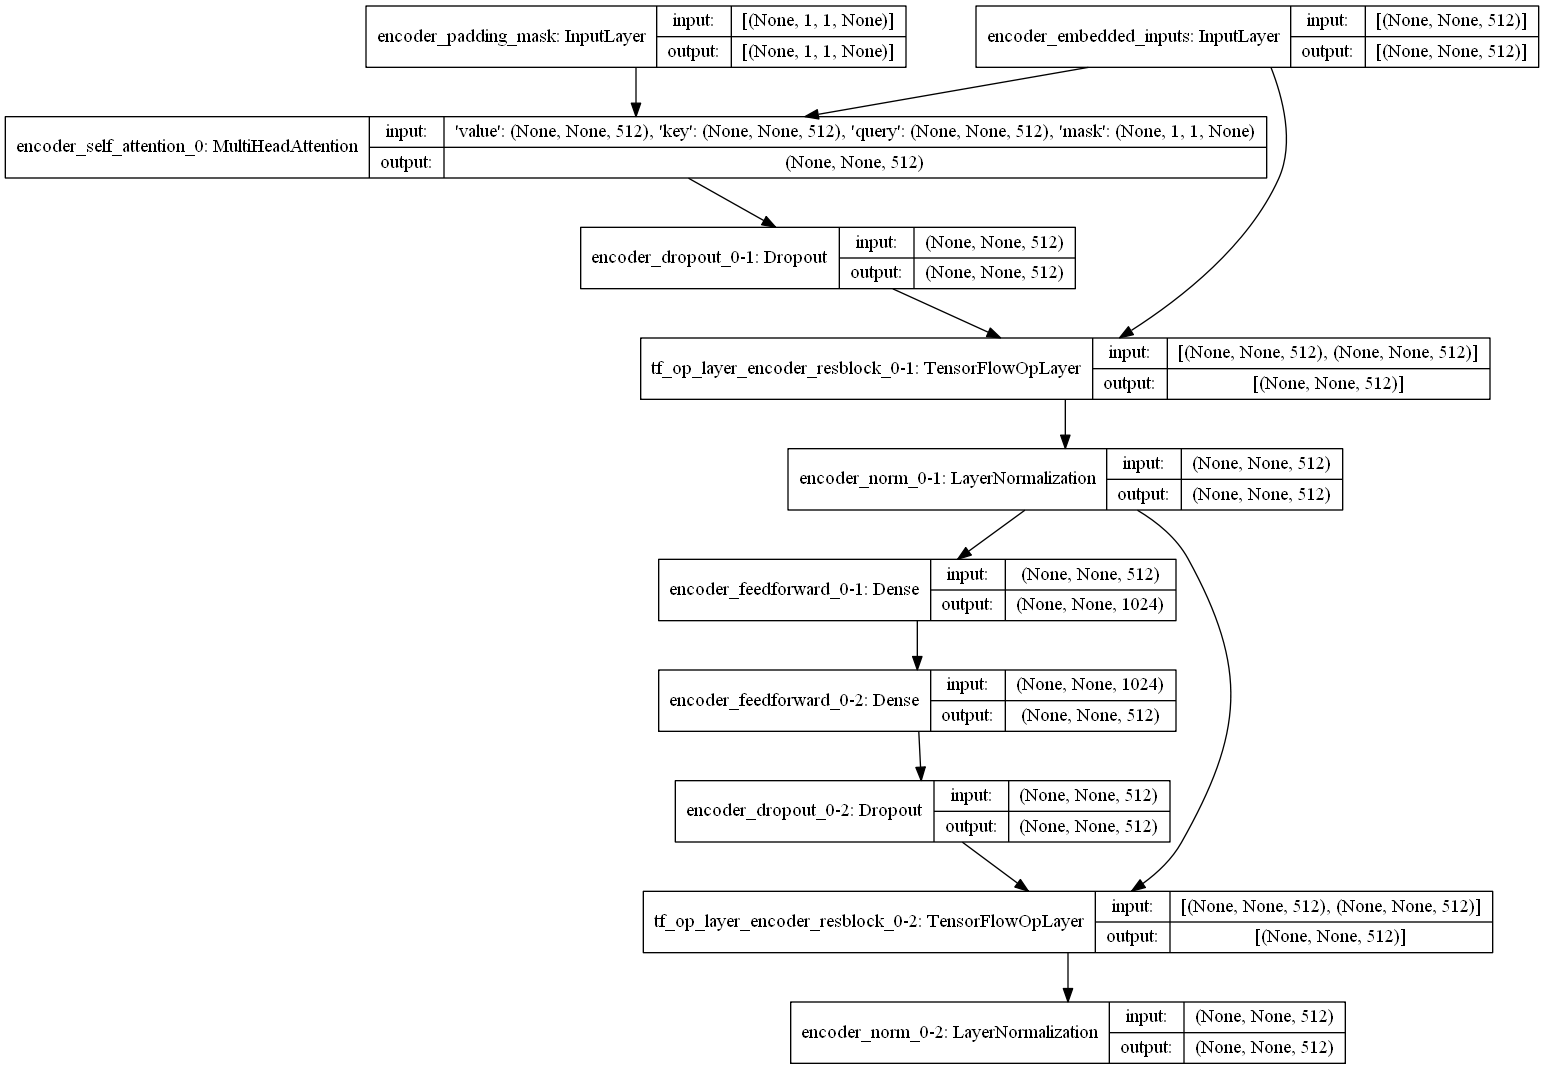

In [20]:
sample_encoder_layer = EncoderLayer(d,n_heads,dff,0,name ='sample_encoder_layer')
utils.plot_model(sample_encoder_layer,show_shapes=True)

In [21]:
def PositionalEncoding(input_tensor):
    # the positional encoding ensures that each dimension and position has an unique marker.
    # in reality the pos range should be equal to the max_len of the sequence, but since I didn't want to define and fix
    # the seq_len and also I wanted the model to handle longer than max_len sequences I used Vocabsize as the length for pos instead.
    
    pos = tf.range(vocabsize,dtype ='float32')
    i = tf.range(d,dtype = 'float32')
    
    angle_rate = 1/1e4**(2*(i//2)/d)
    angle = tf.einsum('i,j->ij',pos,i)
    
    evens = tf.math.sin(angle[:,0::2])
    odds = tf.math.cos(angle[:,1::2])
    
    encoding = tf.concat([evens,odds],axis = 1)
    return encoding[:tf.shape(input_tensor)[1], :]+input_tensor

In [22]:
def Encoder(d,n_heads,n_layers,dff,name = 'encoder'):
    encoder_inputs = Input(shape = (None,),name = 'encoder_tokens')
    padding_mask = Input(shape = (1,1,None),name = 'encoder_padding_mask')
    
    x = layers.Embedding(vocabsize,d,name = 'encoder_embedding')(encoder_inputs)
    x = layers.Lambda(PositionalEncoding,output_shape = (None,d),name = 'position_encoded_inputs')(x)
    
    x = layers.Dropout(0.3,name = 'pre-atten_encoder_dropout')(x,training = True)
    for i in range(n_layers):
        x = EncoderLayer(d,n_heads,dff,i,name = 'encoder_layer')([x,padding_mask])
        
    return Model(inputs=[encoder_inputs,padding_mask],outputs = x,name = name)

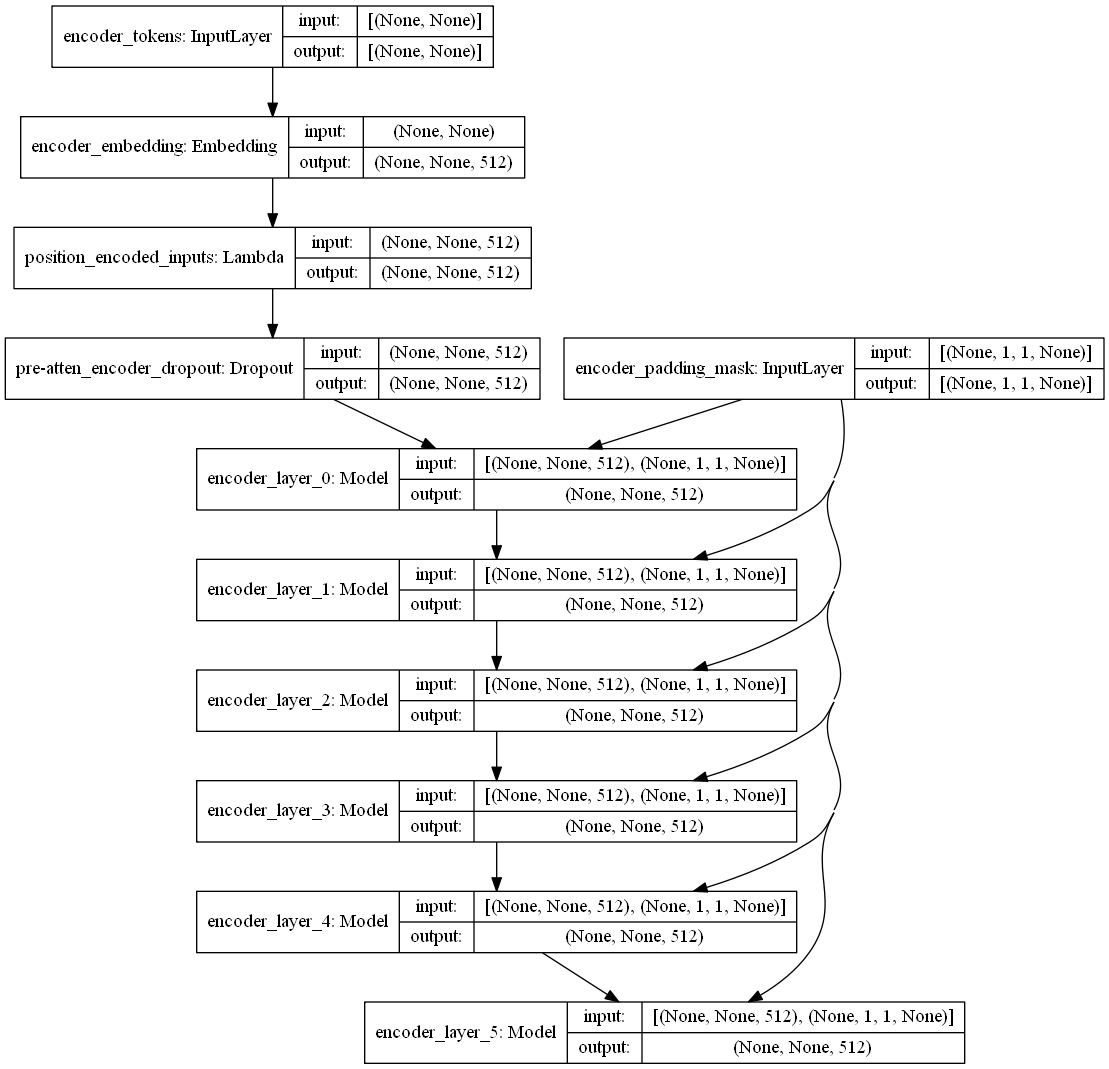

In [23]:
sample_encoder = Encoder(d,n_heads,n_layers,dff,name ='sample_encoder')
utils.plot_model(sample_encoder,show_shapes=True)

In [24]:
def DecoderLayer(d,n_heads,dff,i,name = 'decoder_layer'):
    decoder_inputs=Input(shape = (None,d),name='decoder_embedded_inputs')
    padding_mask = Input(shape = (1,1,None), name = 'decoder_padding_mask')
    encoder_outputs = Input(shape=(None,d),name = 'encoder_outputs')
    forward_mask = Input(shape = (1,None,None),name='decoder_forward_mask')
    
    # first block
    out1 = MultiHeadAttention(d,n_heads,name = 'decoder_self_attention_{}'.format(i))(
        {'value':decoder_inputs,'key':decoder_inputs,'query':decoder_inputs,'mask':forward_mask})
    out1 = layers.Dropout(0.3,name='decoder_dropout_{}-1'.format(i))(out1,training = True)
    out1 = layers.LayerNormalization(
        epsilon=1e-6,name = 'decoder_norm_{}-1'.format(i))(
        tf.add(out1,decoder_inputs,name ='decoder_resblock_{}-1'.format(i)))
    
    # second block
    out2 = MultiHeadAttention(d,n_heads,name = 'decoder_general_attention_{}'.format(i))(
        {'value':encoder_outputs,'key':encoder_outputs,'query':out1,'mask':padding_mask})
    out2 = layers.Dropout(0.3,name='decoder_dropout_{}-2'.format(i))(out2,training = True)
    out2 = layers.LayerNormalization(
        epsilon=1e-6,name = 'decoder_norm_{}-2'.format(i))(
        tf.add(out2,out1,name ='decoder_resblock_{}-2'.format(i)))
    
    out3 = layers.Dense(dff,activation='relu',name = 'decoder_feedforward_{}-1'.format(i))(out2)
    out3 = layers.Dense(d,name = 'decoder_feedforward_{}-2'.format(i))(out3)
    out3 = layers.Dropout(0.3,name='decoder_dropout_{}-3'.format(i))(out3,training = True)
    out3 = layers.LayerNormalization(epsilon=1e-6,name = 'decoder_norm_{}-3'.format(i))(
        tf.add(out3,out2,name ='decoder_resblock_{}-3'.format(i)))
    
    return Model(inputs = [decoder_inputs,encoder_outputs,padding_mask,forward_mask],outputs = out3,name = name+'_{}'.format(i))

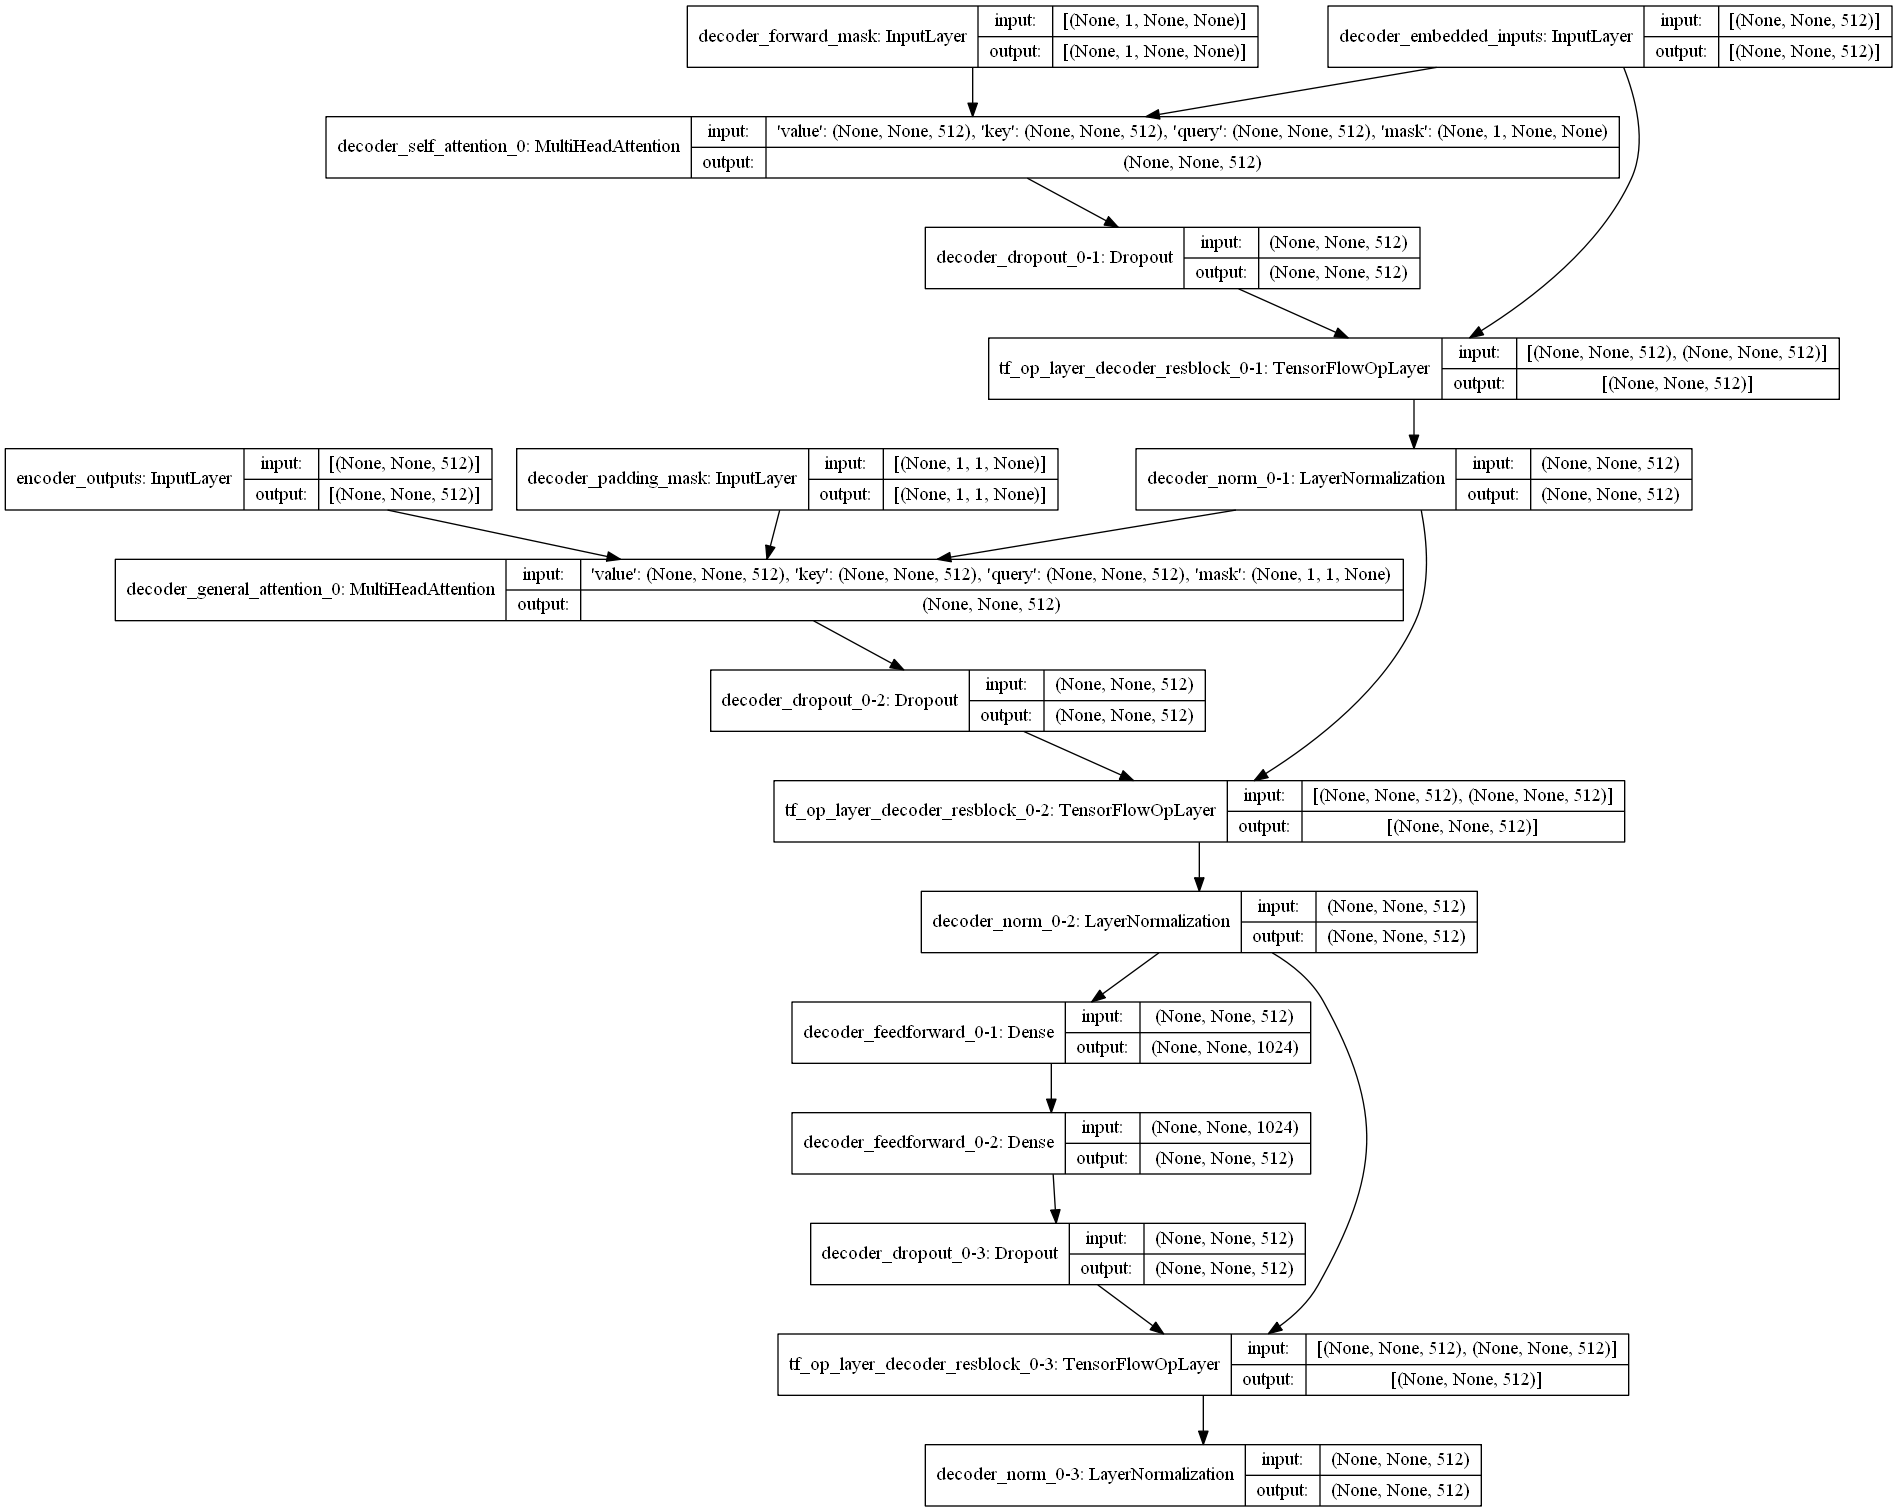

In [25]:
sample_decoder_layer = DecoderLayer(d,n_heads,dff,0,name ='sample_decoder_layer')
utils.plot_model(sample_decoder_layer,show_shapes=True)

In [26]:
def Decoder(d,n_heads,n_layers,dff,name = 'decoder'):
    decoder_inputs = Input(shape = (None,),name='decoder_tokens')
    padding_mask = Input(shape = (1,1,None), name = 'decoder_padding_mask')
    encoder_outputs = Input(shape=(None,d),name = 'encoder_outputs')
    forward_mask = Input(shape = (1,None,None),name='decoder_forward_mask')
    
    x = layers.Embedding(vocabsize,d,name = 'decoder_embedding')(decoder_inputs)
    x = layers.Lambda(PositionalEncoding,output_shape = (None,d),name = 'position_encoded_inputs')(x)
    x = layers.Dropout(0.3,name = 'pre-atten_decoder_dropout')(x,training=True)
    for i in range(n_layers):
        x = DecoderLayer(d,n_heads,dff,i,name = 'decoder_layer')([x,encoder_outputs,padding_mask,forward_mask])
        
    return Model(inputs=[decoder_inputs,encoder_outputs,padding_mask,forward_mask],outputs = x,name = name)

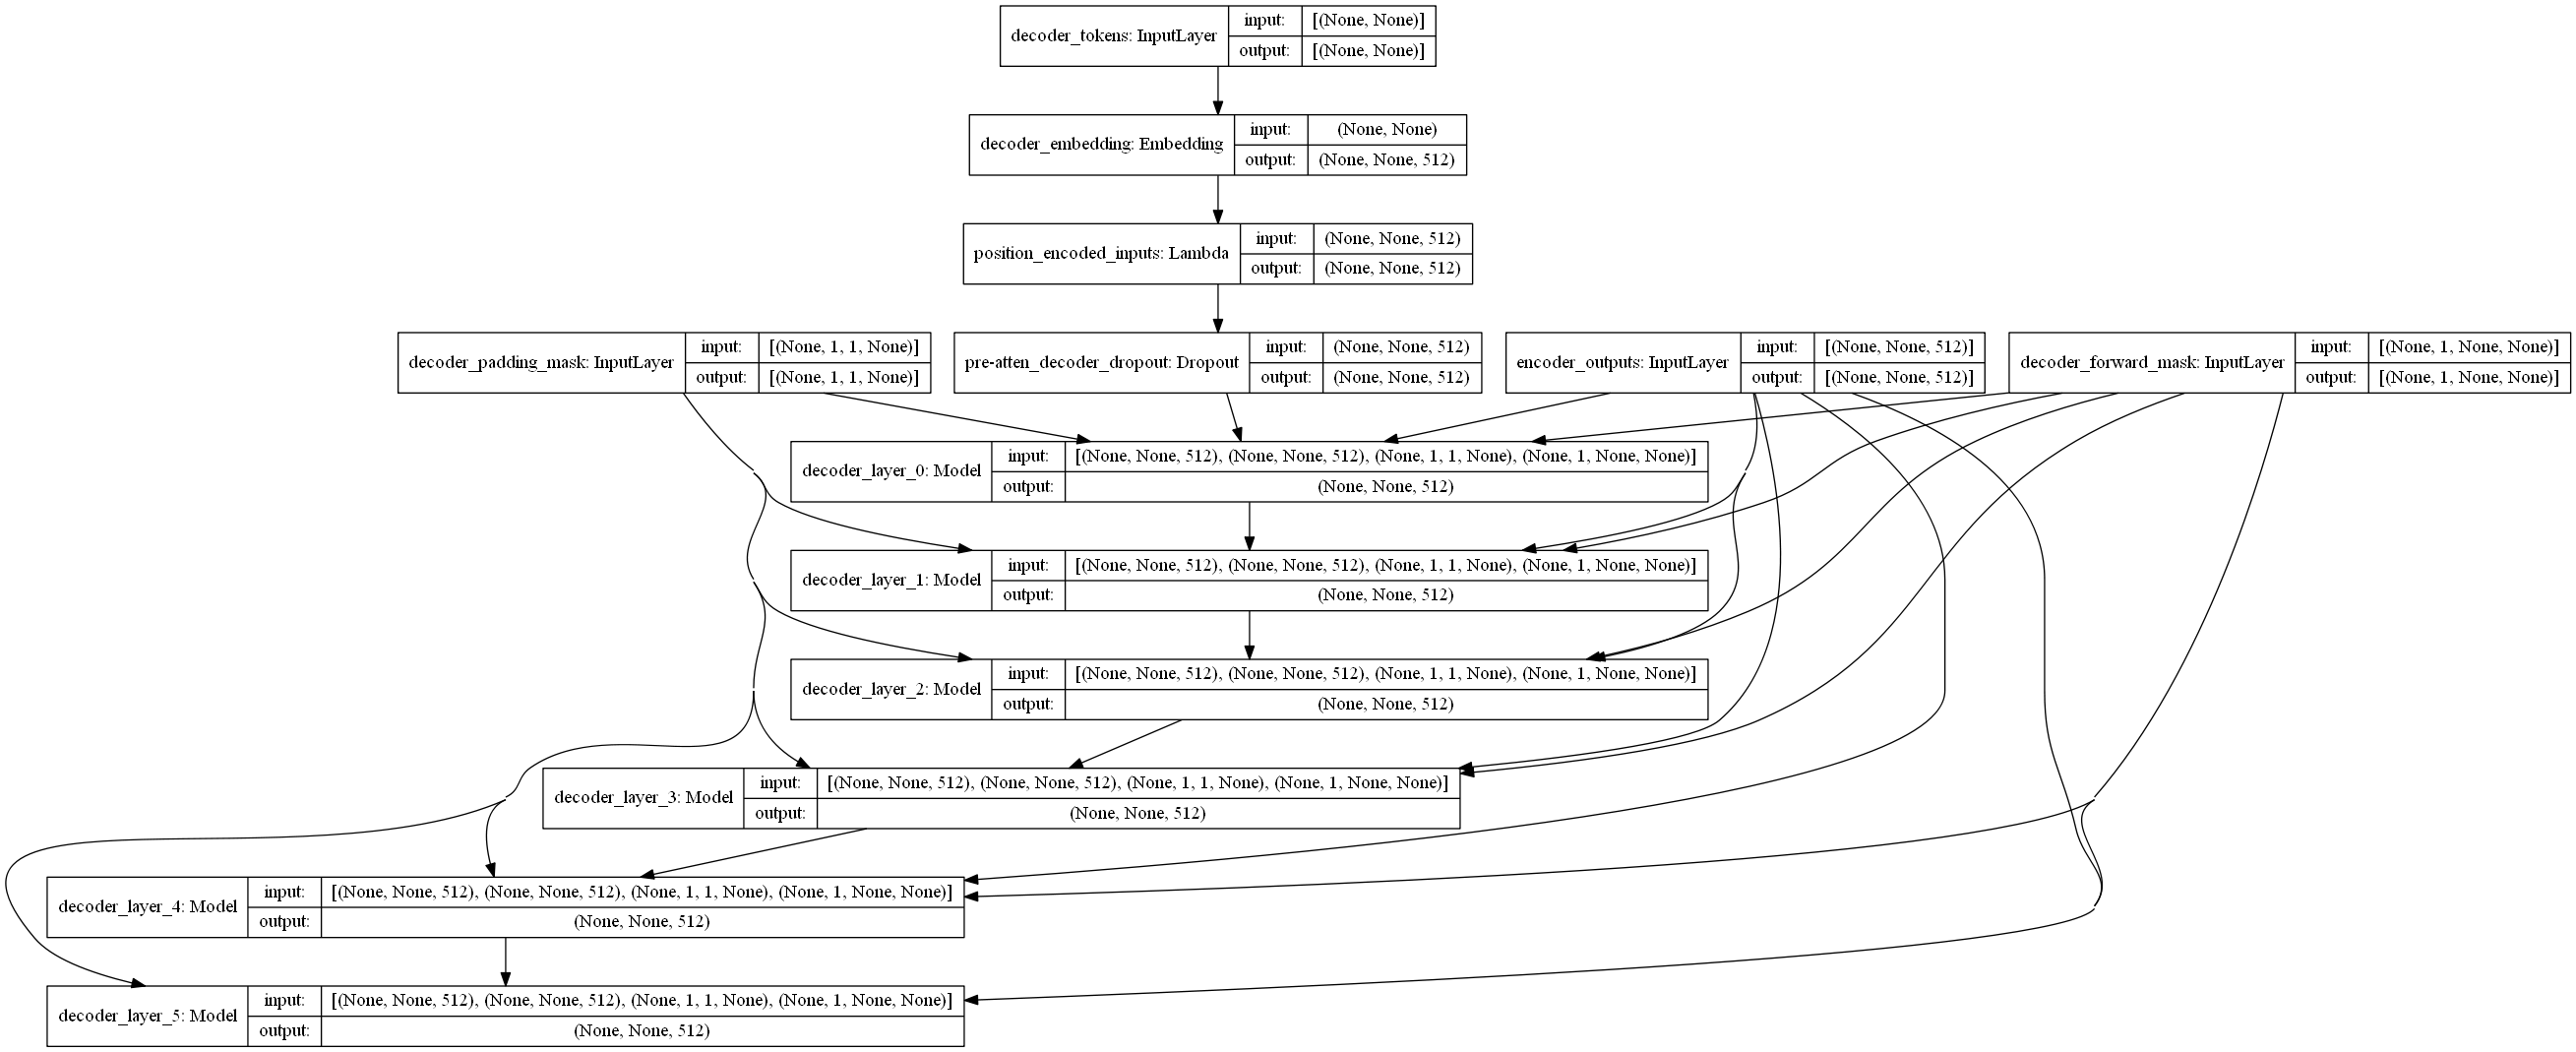

In [27]:
sample_decoder = Decoder(d,n_heads,n_layers,dff,name ='sample_decoder')
utils.plot_model(sample_decoder,show_shapes=True)

In [28]:
# the masks are created before they even get encoded so they are based on dims (batchsize,seq_len)
# however as we actually apply the masks in the multihead attention layer after QdotK 
# so we need to make them compatable with dims = (batchsize,n_heads,seq_lenQ,seq_lenK)
# so we can convert dims to (batchsize,1,1,seq_len)
# the forward masks target dim is (batchsize,1,seq_lenQ,seq_lenK)

def create_padding_mask(input_tensor):   
    mask = tf.cast(tf.math.equal(input_tensor, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_forward_mask(input_tensor):
    l = tf.shape(input_tensor)[1]
    padding_mask = create_padding_mask(input_tensor)
    forward_mask = 1-tf.linalg.band_part(tf.ones((l,l)),-1,0)
    return tf.maximum(forward_mask,padding_mask)

In [29]:
def Transformer(d,n_heads,n_layers,dff,name = 'transformer'):
    encoder_inputs = Input(shape = (None,),name = 'encoder_tokens')
    decoder_inputs = Input(shape = (None,),name = 'decoder_tokens')
    
    # need to use lambda layer to carry the shapes through the keras framework
    encoder_padding_mask = layers.Lambda(create_padding_mask, output_shape=(1, 1, max_len),name='encoder_padding_mask')(encoder_inputs)
    decoder_forward_mask = layers.Lambda(create_forward_mask, output_shape=(1, max_len-1, max_len-1), name = 'decoder_forward_mask')(decoder_inputs)
    decoder_padding_mask = layers.Lambda(create_padding_mask, output_shape=(1, 1, max_len),name='decoder_padding_mask')(encoder_inputs)
    
    encoder_outputs = Encoder(d,n_heads,n_layers,dff)([encoder_inputs,encoder_padding_mask])
    decoder_outputs = Decoder(d,n_heads,n_layers,dff)([decoder_inputs,encoder_outputs,decoder_padding_mask,decoder_forward_mask])
    
    predictions = layers.Dense(vocabsize)(decoder_outputs)
    return Model(inputs = [encoder_inputs,decoder_inputs],outputs=predictions, name = name)

In [30]:
tf.keras.backend.clear_session()

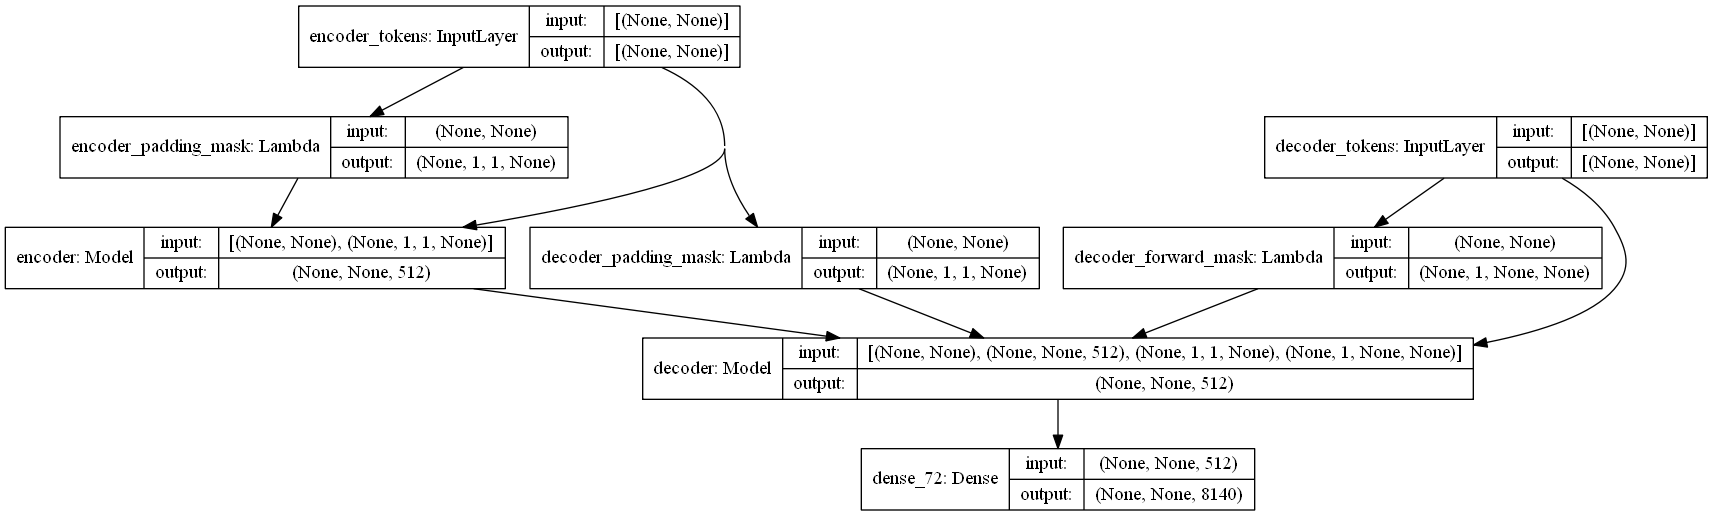

In [31]:
sample_transformer = Transformer(d,n_heads,n_layers,dff,name ='sample_transformer')
utils.plot_model(sample_transformer,show_shapes=True)

In [32]:
# mask your loss function since you have padding still
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True,reduction='none')

def compute_loss(real,pred):
    loss = loss_function(real,pred)
    mask = 1-tf.cast(tf.math.equal(real,0),'float32')
    loss*=mask
    return tf.reduce_mean(loss)

In [33]:

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d = d
        self.d = tf.cast(self.d, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

In [34]:
transformer = Transformer(d,n_heads,n_layers,dff,name ='transformer')

In [35]:
# custom schedule as described by the paper. I think it's because in the beginning the gradients are rough and you need to ramp the
# learning rate slowly as the gradients become smoother in later steps you can achieve better efficiency via higher learning rates

lr = CustomSchedule(d)

optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(real, pred):
    real = tf.reshape(real, shape=(-1, max_len - 1))
    accuracy = tf.metrics.SparseCategoricalAccuracy()(real, pred)
    return accuracy

transformer.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 3

transformer.fit(dataset, epochs=EPOCHS)

In [82]:
transformer.save_weights('transformer_trained_model', save_format='tf')

In [83]:
def evaluate(sentence):
    sentence = preprocess(sentence)

    sentence = start + tokenizer.encode(sentence) + end
    sentence=tf.expand_dims(sentence,axis=0)

    output = tf.expand_dims(start, 0)
    for i in range(max_len):
        predictions = transformer(inputs=[sentence, output], training=False)

        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, end[0]):
            break

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence